<a href="https://colab.research.google.com/github/Ann-pixel/ML-dog-vision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End to end Multiclass Dog-breed classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlowHub

### 1. Problem
Identifying the breed of a dog, given a picture of that dog.


### 2. Data
The data we are using is from Kaggle's dogbreed identification classification.
https://www.kaggle.com/c/dog-breed-identification#

### 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
The evaluation is a file wiht prediction probabilities for each dog breed of each test image.

### 4. Features
Some information about the data.
* We're dealing with images(unstructured data) so it is probably best we use deep learning/transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10k+ images in the train set(images have labels.)
* There are around 10k+ images in the test set (images have no labels-we predict them)

In [ ]:
#unzip zipped file using code.
# !unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision"

### Getting our workspace ready
* import TensorFlow 2.x
* import TensorFlow Hub
* Make sure we're using a GPU.

In [35]:
#import tensorflow into our google colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version",tf.__version__ )
print("TF Hub version", hub.__version__ )

#Check for GPU availablility
print("GPU", "available!!!" if tf.config.list_physical_devices("GPU") else "not available")

TF version 2.7.0
TF Hub version 0.12.0
GPU available!!!


## Gettting our data ready(turing into Tensors)
With all machine learning models, our data has to be in numerical format.

Lets start by accessing our data and checking out our labels

In [36]:
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     5d965216fc63e0aac965ca0f0324ee62  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


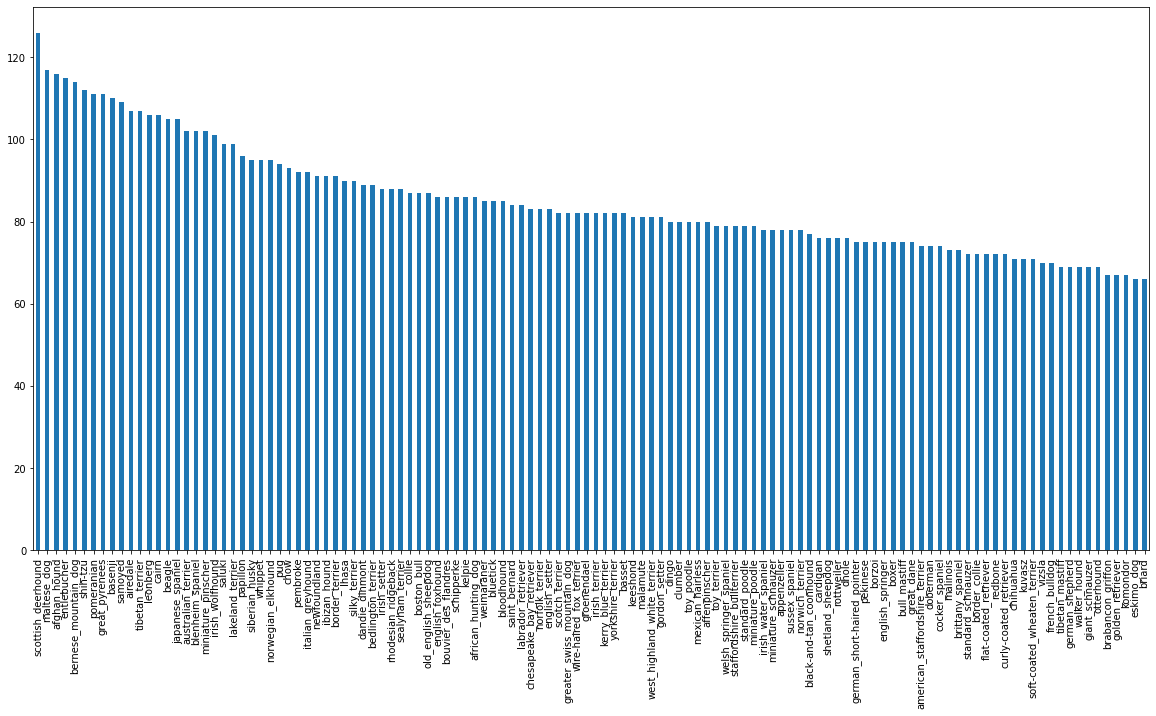

In [37]:
#how many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [38]:
labels_csv["breed"].value_counts().median()

82.0

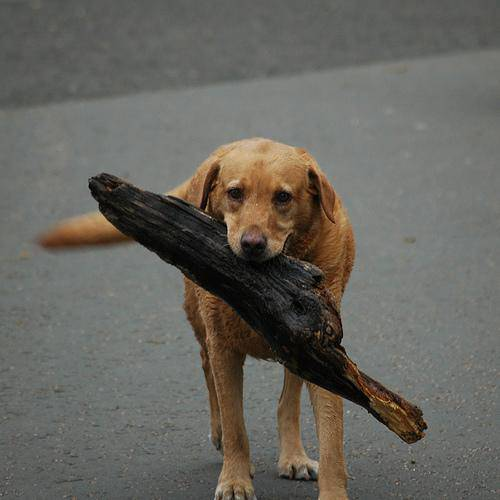

In [39]:
#Lets view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels
lets get a list of all our images and their path names

In [40]:
#Create a pathname from image's ID
filenames = ["drive/MyDrive/Dog Vision/train/"+ fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [41]:
#Check whether number of filenames matches the number of actual image files.
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("filenames match actual files.")
else:
  print("filenames dont match the actual files")

filenames match actual files.


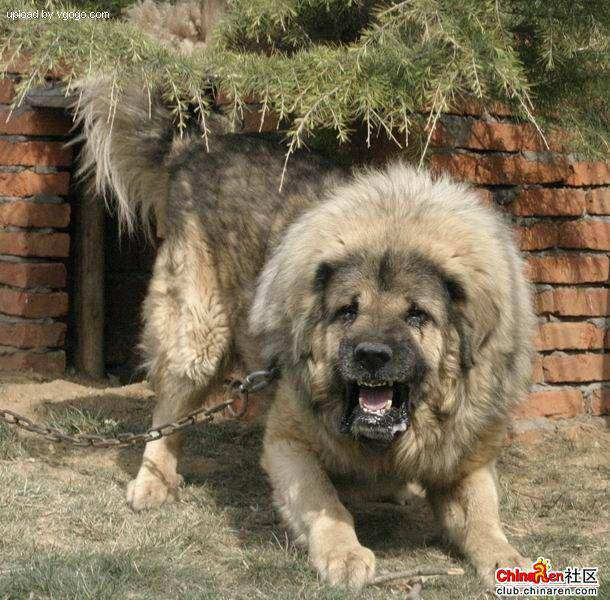

In [42]:
Image(filenames[9000])

Since we have our file paths in a list. Let's prepare our labels.

In [43]:
import numpy as np
labels= np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [44]:
len(labels)

10222

In [45]:
# See if the number of labels matches the number of files (a workaround to find missing data for unstructured data.)
if len(labels) == len(filenames):
  print("Number of filenames matches the number of labels! no missing data!")
else:
  print("Labels dont match the number of filenames. There must be some missing data!")

Number of filenames matches the number of labels! no missing data!


In [46]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [47]:
len(unique_breeds)

120

In [49]:
#Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [50]:
#Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels), len(labels)

(10222, 10222)

In [51]:
#Example: Turning boolean array into integers
print(labels[0]) #original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in the boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where sample label occurs.

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [52]:
print(labels[2]) #name of the breed
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [53]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set
SInce the dataset from Kaggle doesnt come with a validation set, we're going to create our own.

In [54]:
#Setup X and y variables
X= filenames
y= boolean_labels

We're goinf to start off experimenting with 1000 images and increase as needed


In [55]:
#Set number of images to use for experimenting
#magic function in GColab.
NUM_IMAGES = 1000 #@param {type:"slider", min: 1000, max:10000, step: 1000}

In [56]:
#Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val= train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES],
                                                 test_size= 0.2,
                                                 random_state = 42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [57]:
#Lets look at the training data
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

## Preprocessing images(turning images into Tensors)
To preprocess our images into Tensors we're going to wite a function that does a few things"
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1 values)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified image


In [58]:
# Convert an image into a numpy array
from matplotlib.pyplot import imread
image= imread(filenames[42])
image.shape

(257, 350, 3)

In [59]:
image.max(), image.min()

(255, 0)

In [60]:
#Turn image into a tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a tensor. lets make a function to preprocess them
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1 values)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified image


In [61]:
# Define image size
IMG_SIZE = 224

#Function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  '''
  Takes an image file path and turns it into a Tensor
  '''
  # Read in an image file.
  image = tf.io.read_file(image_path)

   #convert the color channel values form 0-255 to 0-1 values
  image = tf.image.decode_jpeg(image, channels=3)

  #Turn the jpg image into Tensors with 3 color channels(RGB)
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize the image to our desired size(224, 224)
  image = tf.image.resize(image, size = (IMG_SIZE, IMG_SIZE))
  return image

## Turning our data into batches
Why?--
Let's say you're trying to process 10000+ images in one go.. they might not fit into memory
So' that's why we do about 32 (batch size) images at a time. You can manually change batch size if need be.
In order to use Tensor Flow effectively, we need our data in the form of Tensor Tuples which look like this:
`(image, label)`

In [62]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):

  '''
  Takes an image file path name and the associated label,
  processes the image and returns the image and label as a tuple
  '''
  image = process_image(image_path)
  return image, label

In [63]:
get_image_label(X[42], tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into a tuple of tensors, in the form `(image, label)`, let's make a function to turn all our data X, y into batches.

In [64]:
# Define a batchsize
BATCH_SIZE= 32

#Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data= False):
  '''
  Create batches of data out of image(X) and label(y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it is validation data.
  Also accepts test data as input (no labels)
  '''
  #If the data is a test dataset, we dont have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is validation data set, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                              tf.constant(y))) #labels
    data_batch= data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  #Training dataset
  else:
    print("Creating training data batches..")
    #Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    #Shuffling pathnames and labels before mapping image processor function is faster than shuffling images.
    data = data.shuffle(buffer_size = len(X))
    
    #Create (image, label) tuple.- this also turns the image path into a preprocessed image.
    data = data.map(get_image_label)
    
    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [65]:
#Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data= True)

Creating training data batches..
Creating validation data batches...


In [66]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [67]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualising data batches 
Our data is now in batches, however, these can be a little hard to understand/comprehend. let's visualise them

In [74]:
import matplotlib.pyplot as plt

#create a function for viewing image in a data batch

def show_25_images(images, labels):
  '''
  Displays a plot of 25 images and their labels from data batch.
  '''
  #set up figure
  plt.figure(figsize = (10, 10))

  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    #Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    #Display an image
    plt.imshow(images[i])
    #add the image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn gridline off
    plt.axis("off")

In [70]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# train_images, train_labels

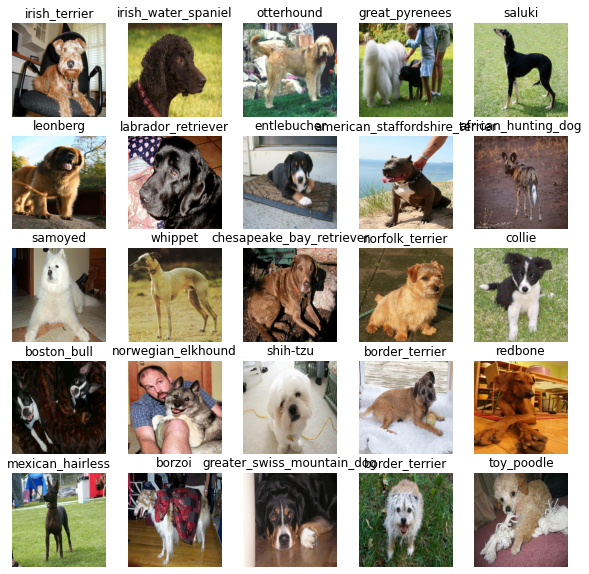

In [75]:
#Now let's visualize our data in a training batch
show_25_images(train_images, train_labels)

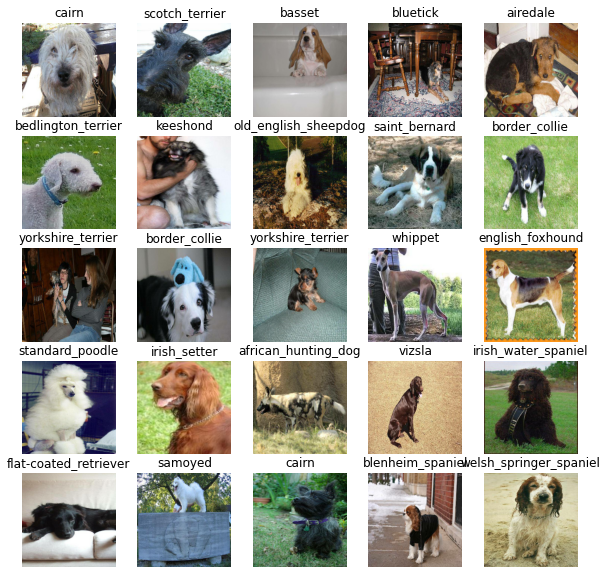

In [76]:
#Now let's visualze our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)